# Custom Extensions in APEBench - Example of a new metric

This is an example of how to extend the components system in `APEBench`.

In [1]:
import jax
import jax.numpy as jnp
import apebench
import seaborn as sns

/home/felix/miniconda3/envs/apebench_dev/lib/python3.12/site-packages/trainax/_general_trainer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Register a new entry in the corresponding dictionary of the component. Here,
this is `apebench.components.metric_dict`. Ensure that your constructor complies
with the required interface. Here, this is supposed to the a function which
takes the `"metric_config"` (for example to supply further arguments to your
metric). It must then return another function which processes a `pred` array and
`ref` array to a scalar value. These arrays always have a leading batch axis
(can be singleton), a subsequent channel axis (can be singleton), and then one,
two, or three spatial axes for 1d, 2d, or 3d data, respectively.

Let's implement a very unnecessary metric which computes the difference between
the two arrays and extracts the zeroth-channel and third spatial point (assuming
we are in 1d) and then takes the mean over the batch axis.

In [2]:
apebench.components.metric_dict[
    "my_crazy_metric"
] = lambda metric_config: lambda pred, ref: jnp.mean((pred - ref)[..., 0, 3])

Let's instantiate the difficulty advection scenario, reduce the number of
training steps to 100 (to have the notebook run quicker) and have this new
metric as the only metric that is supposed to be reported.

In [3]:
adv_scene = apebench.scenarios.difficulty.Advection(
    optim_config="adam;100;constant;1e-3",
    report_metrics="my_crazy_metric",
)

Execute the scenario

In [4]:
data, nets = adv_scene()

E: 00000, B: 00099: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


Then we can melt the new metric out of the results

In [5]:
metrics_data = apebench.melt_metrics(data, metric_name="my_crazy_metric")

In [6]:
metrics_data

,seed,scenario,task,net,train,scenario_kwargs,time_step,my_crazy_metric
0,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},1,0.004273
1,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},2,0.009067
2,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},3,0.012390
3,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},4,0.005566
4,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},5,-0.007298
...,...,...,...,...,...,...,...,...
195,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},196,0.631970
196,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},197,0.624528
197,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},198,0.637511
198,0,1d_diff_adv,predict,Conv;34;10;relu,one,{},199,0.663936


And visualize its rollout

<Axes: xlabel='time_step', ylabel='my_crazy_metric'>

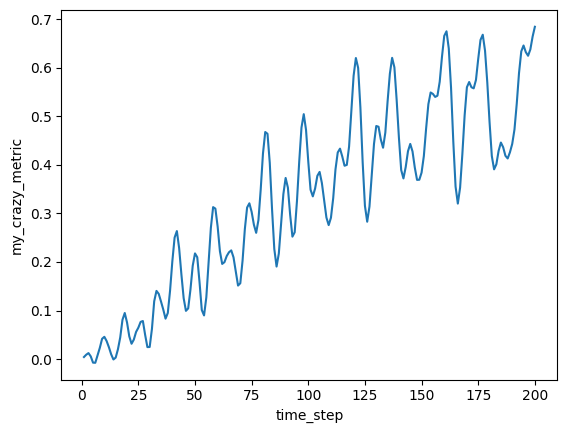

In [7]:
sns.lineplot(
    data=metrics_data,
    x="time_step",
    y="my_crazy_metric",
)